<a href="https://colab.research.google.com/github/miguel-kjh/Malaria_cell_detector./blob/master/Malaria_cell_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.models import *
from keras.layers import *
from keras.applications import VGG16
from keras import layers
from keras import optimizers
from keras import utils
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [22]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
def generatePlot(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
   
  epochs = range(len(acc))
   
  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
   
  plt.figure()
   
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
   
  plt.show()
  
def fit_validation(model,train,validation,epochs=15):
  return model.fit_generator(
            train,
            steps_per_epoch=train.samples // batch_size,
            epochs=epochs, 
            validation_data=validation,
            validation_steps=validation.samples // batch_size)
  

# Se monta el directorio 

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Comprobación de datos

C100P61ThinF_IMG_20150918_144104_cell_128.png
C100P61ThinF_IMG_20150918_144104_cell_131.png
C100P61ThinF_IMG_20150918_144104_cell_144.png
C100P61ThinF_IMG_20150918_144104_cell_21.png
C100P61ThinF_IMG_20150918_144104_cell_25.png


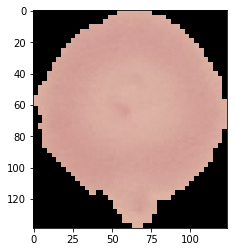

In [0]:
!ls "/content/drive/My Drive/Colab Notebooks/Cell malaria/Uninfected" | head -5
pil_im_uninfected = Image.open('/content/drive/My Drive/Colab Notebooks/Cell malaria/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_25.png', 'r')
plt.imshow(np.asarray(pil_im_uninfected))

C100P61ThinF_IMG_20150918_144104_cell_162.png
C100P61ThinF_IMG_20150918_144104_cell_163.png
C100P61ThinF_IMG_20150918_144104_cell_164.png
C100P61ThinF_IMG_20150918_144104_cell_165.png
C100P61ThinF_IMG_20150918_144104_cell_166.png


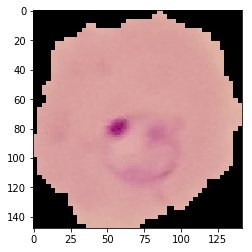

In [0]:
!ls "/content/drive/My Drive/Colab Notebooks/Cell malaria/Parasitized" | head -5
pil_im_infected = Image.open('/content/drive/My Drive/Colab Notebooks/Cell malaria/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png', 'r')
plt.imshow(np.asarray(pil_im_infected))

# Generación de Imagenes

In [75]:
image_size=60
data_dir = '/content/drive/My Drive/Colab Notebooks/Cell malaria'
batch_size = 15
datagen = ImageDataGenerator(rescale = 1/255.,
                             horizontal_flip = True,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             zoom_range = 0.3,
                             rotation_range = 30,
                             validation_split=0.1
                            )

train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary',
        subset="training")

validation_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary',
        subset="validation")

Found 9003 images belonging to 3 classes.
Found 1000 images belonging to 3 classes.


#** Uso de la Red VGG16**

## *Cargamos la VGG16 y congelamos sus pesos*

In [76]:
vgg_conv = VGG16(weights='imagenet', 
                 include_top=False, 
                 input_shape=(image_size, image_size, 3))

for layer in vgg_conv.layers[:7]:
    layer.trainable = False
    
for layer in vgg_conv.layers[11:]:
    layer.trainable = False

    
    
for layer in vgg_conv.layers:
    print(layer, layer.trainable)
vgg_conv.summary()

<keras.engine.input_layer.InputLayer object at 0x7fc1c0848780> False
<keras.layers.convolutional.Conv2D object at 0x7fc1c0848a20> False
<keras.layers.convolutional.Conv2D object at 0x7fc1c08485c0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc1c092cef0> False
<keras.layers.convolutional.Conv2D object at 0x7fc1c086b4e0> False
<keras.layers.convolutional.Conv2D object at 0x7fc1c085e588> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc2bcf880f0> False
<keras.layers.convolutional.Conv2D object at 0x7fc1c093ef28> True
<keras.layers.convolutional.Conv2D object at 0x7fc1c0956ba8> True
<keras.layers.convolutional.Conv2D object at 0x7fc1c089b5f8> True
<keras.layers.pooling.MaxPooling2D object at 0x7fc1c08a03c8> True
<keras.layers.convolutional.Conv2D object at 0x7fc1c08a0c88> False
<keras.layers.convolutional.Conv2D object at 0x7fc1bfb184e0> False
<keras.layers.convolutional.Conv2D object at 0x7fc1bfb2bb00> False
<keras.layers.pooling.MaxPooling2D object at 0x7fc1c0378278> Fal

## RED NEURONAL(capa densa)

In [77]:
x = Flatten()(vgg_conv.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)
model_vgg16 = Model(inputs = vgg_conv.input, outputs = x)
 

model_vgg16.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 60, 60, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 60, 60, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 60, 60, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 30, 30, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 30, 30, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 30, 30, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 15, 15, 128)       0         
__________

## Compilación y Entrenamiento

In [78]:
model_vgg16.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])
print("Compilado...")


# TRAINING --------------------------------------------------

epochs = 15
history_model_vgg16 = fit_validation(model_vgg16,train_generator,validation_generator)

Compilado...
Epoch 1/15
600/600 [==============================] - 53s 88ms/step - loss: 0.3961 - acc: 0.8087 - val_loss: 0.2257 - val_acc: 0.9192
Epoch 2/15
600/600 [==============================] - 47s 78ms/step - loss: 0.2409 - acc: 0.9139 - val_loss: 0.2227 - val_acc: 0.9188
Epoch 3/15
600/600 [==============================] - 50s 83ms/step - loss: 0.2110 - acc: 0.9240 - val_loss: 0.2117 - val_acc: 0.9015
Epoch 4/15
600/600 [==============================] - 48s 81ms/step - loss: 0.2105 - acc: 0.9263 - val_loss: 0.1815 - val_acc: 0.9442
Epoch 5/15
600/600 [==============================] - 48s 80ms/step - loss: 0.2025 - acc: 0.9288 - val_loss: 0.2021 - val_acc: 0.9259
Epoch 6/15
600/600 [==============================] - 49s 82ms/step - loss: 0.2022 - acc: 0.9298 - val_loss: 0.1673 - val_acc: 0.9442
Epoch 7/15
600/600 [==============================] - 47s 79ms/step - loss: 0.1977 - acc: 0.9308 - val_loss: 0.1751 - val_acc: 0.9320
Epoch 8/15
600/600 [=============================

# Red convolutiva, propia

In [63]:
#creating sequential model
model_conv=Sequential()
model_conv.add(Conv2D(filters=32,kernel_size=3,activation="relu",input_shape=(image_size,image_size,3)))
model_conv.add(MaxPooling2D(2,2))

model_conv.add(Conv2D(filters=32,kernel_size=3,activation="relu"))
model_conv.add(MaxPooling2D(2,2))

model_conv.add(Conv2D(filters=32,kernel_size=3,activation="relu"))
model_conv.add(MaxPooling2D(2,2))

model_conv.add(Flatten())
model_conv.add(Dense(256,activation="relu"))
model_conv.add(Dropout(0.3))
model_conv.add(Dense(1,activation="sigmoid"))
model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 58, 58, 32)        896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 800)               0         
__________

##      Compilación y Entramiento

In [64]:
model_conv.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])
print("Compilado...")


# TRAINING --------------------------------------------------

history = fit_validation(model_conv,train_generator,validation_generator)

Compilado...
Epoch 1/15
600/600 [==============================] - 47s 78ms/step - loss: 0.5613 - acc: 0.7086 - val_loss: 0.3843 - val_acc: 0.8467
Epoch 2/15
600/600 [==============================] - 44s 74ms/step - loss: 0.3250 - acc: 0.8702 - val_loss: 0.2566 - val_acc: 0.9066
Epoch 3/15
600/600 [==============================] - 43s 71ms/step - loss: 0.2923 - acc: 0.8904 - val_loss: 0.3092 - val_acc: 0.8660
Epoch 4/15
600/600 [==============================] - 45s 75ms/step - loss: 0.2723 - acc: 0.8969 - val_loss: 0.2348 - val_acc: 0.8914
Epoch 5/15
600/600 [==============================] - 43s 72ms/step - loss: 0.2614 - acc: 0.9024 - val_loss: 0.2414 - val_acc: 0.9107
Epoch 6/15
600/600 [==============================] - 44s 74ms/step - loss: 0.2524 - acc: 0.9062 - val_loss: 0.2263 - val_acc: 0.8975
Epoch 7/15
600/600 [==============================] - 44s 73ms/step - loss: 0.2490 - acc: 0.9099 - val_loss: 0.2477 - val_acc: 0.9056
Epoch 8/15
600/600 [=============================

# Interpretación de datos

Red Convolutiva con los pesos de la vgg16


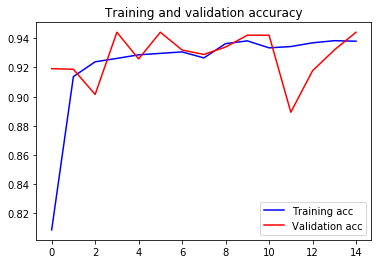

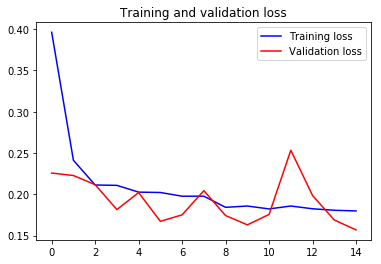

In [79]:
print("Red Convolutiva con los pesos de la vgg16")
generatePlot(history_model_vgg16)

Red Convolutiva propia


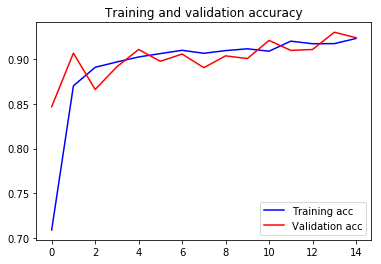

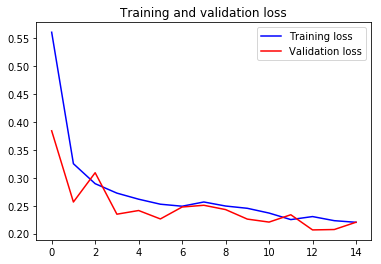

In [74]:
print("Red Convolutiva propia")
generatePlot(history)